In [245]:
import pandas as pd
import os
import joblib  # Import joblib instead of pickle
from pathlib import Path
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from src.eeg_analysis.visualization.my_custom_style import set_custom_style
from src.eeg_analysis.utils.helpers import detect_and_interpolate_outliers

# Load the Excel file
main_dir = 'E:/Caffeine_data/'
file_path = 'E:/Caffeine_data/caffeine_labels.xlsx'
try:
    df = pd.read_excel(file_path)
    print("Excel file loaded successfully.")
except FileNotFoundError:
    warnings.warn(f"Warning: The file at {file_path} was not found.", UserWarning)
    df = None
except Exception as e:
    warnings.warn(f"Warning: An error occurred while loading the Excel file: {e}", UserWarning)
    df = None

if df is not None:
    # Print column names to verify
    print(df.columns)

    # Initialize the dictionary for groups
    groups = {'A': [], 'B': []}

    # Populate the dictionary based on the group label
    for index, row in df.iterrows():
        try:
            label = row['Patient_Label'] 
            group = row['Group_Number']  

            if group == 1:
                groups['A'].append(label)
            elif group == 2:
                groups['B'].append(label)
        except KeyError as e:
            warnings.warn(f"Warning: The column {e} is missing from the Excel file.", UserWarning)
        except Exception as e:
            warnings.warn(f"Warning: An error occurred while processing the row {index}: {e}", UserWarning)

    print(groups)

    epoch_names = ['preop_rest', 'emergence', 'pacu_rest']
    region_names = ['prefrontal', 'frontal', 'parietal', 'central', 'temporal', 'occipital']
    fbands = ['alpha', 'delta', 'theta', 'beta', 'gamma']

    # Initialize data structures
    win_center = {}
    psd = {}
    reg_fit_slope = {}
    fooof_fit_slope = {}
    fband_power_reg = {fband: {} for fband in fbands}
    fband_power_fooof = {fband: {} for fband in fbands}
    fband_power_abs = {fband: {} for fband in fbands}
    group_label = {}

    for p_id in range(1, 72):
        p_name = f'CA-{p_id:02}'
        base_results_dir = Path(f'E:/Caffeine_data/CA-{p_id:02}/analysis_results_v2')
        filename = base_results_dir / f'CA-{p_id:02}_power_spectral.pkl'

        if not filename.exists():
            # warnings.warn(f"Warning: The file at {filename} was not found.", UserWarning)
            continue

        loaded_power_spectral = joblib.load(filename)  

        win_center[p_name] = {}
        psd[p_name] = {}
        reg_fit_slope[p_name] = {}
        fooof_fit_slope[p_name] = {}
        for region in region_names:
            win_center[p_name][region] = {}
            psd[p_name][region] = {}
            reg_fit_slope[p_name][region] = {}
            fooof_fit_slope[p_name][region] = {}
            for epoch in epoch_names:
                win_center[p_name][region][epoch] = loaded_power_spectral.window_average_tfr[region][epoch].times
                psd[p_name][region][epoch] = loaded_power_spectral.window_average_tfr[region][epoch].data
                reg_fit_slope[p_name][region][epoch] = detect_and_interpolate_outliers(
                    -loaded_power_spectral.regresssion_ap_fit_slope[region][epoch].flatten(), iqr_factor=1
                )
                fooof_fit_slope[p_name][region][epoch] = detect_and_interpolate_outliers(
                    loaded_power_spectral.fooof_aperiodic_fit_slope[region][epoch].flatten(), iqr_factor=1
                )

                for fband in fbands:
                    if p_name not in fband_power_reg[fband]:
                        fband_power_reg[fband][p_name] = {}
                    if p_name not in fband_power_fooof[fband]:
                        fband_power_fooof[fband][p_name] = {}
                    if p_name not in fband_power_abs[fband]:
                        fband_power_abs[fband][p_name] = {}

                    if region not in fband_power_reg[fband][p_name]:
                        fband_power_reg[fband][p_name][region] = {}
                    if region not in fband_power_fooof[fband][p_name]:
                        fband_power_fooof[fband][p_name][region] = {}
                    if region not in fband_power_abs[fband][p_name]:
                        fband_power_abs[fband][p_name][region] = {}    

                    # freq band powers relative to the aperiodic component calculated using linear regression method
                    curr_fband_data_reg = loaded_power_spectral.fband_power_relative_reg_ap[region][epoch][fband].flatten()
                    if np.any(~np.isnan(curr_fband_data_reg)):
                        fband_power_reg[fband][p_name][region][epoch] = detect_and_interpolate_outliers(curr_fband_data_reg, iqr_factor=1)
                    else:
                        fband_power_reg[fband][p_name][region][epoch] = curr_fband_data_reg

                    # if fband not in fband_power_fooof:
                    #     fband_power_fooof[fband] = {}

                    # freq band powers extracted using FOOOF (relative to the FOOOF aperiodic component)
                    if fband == 'delta':
                        curr_fband_data_fooof = loaded_power_spectral.fooof_periodic_parameters[region][epoch][fband]['avg_power_relative'].flatten()
                    else:
                        curr_fband_data_fooof = loaded_power_spectral.fooof_periodic_parameters[region][epoch][fband]['amplitude'].flatten()

                    if np.any(~np.isnan(curr_fband_data_fooof)):
                        fband_power_fooof[fband][p_name][region][epoch] = detect_and_interpolate_outliers(curr_fband_data_fooof, iqr_factor=1)
                    else:
                        fband_power_fooof[fband][p_name][region][epoch] = curr_fband_data_fooof

                    
                    # Absolute freq band powers (freq band boundaries calculated using FOOOF)
                    curr_fband_data_abs = loaded_power_spectral.fooof_periodic_parameters[region][epoch][fband]['avg_power_absolute'].flatten()
                    if np.any(~np.isnan(curr_fband_data_fooof)):
                        fband_power_abs[fband][p_name][region][epoch] = detect_and_interpolate_outliers(curr_fband_data_abs, iqr_factor=1)
                    else:
                        fband_power_abs[fband][p_name][region][epoch] = curr_fband_data_abs
              

        if p_name in groups['A']:
            group_label[p_name] = 'A'
        elif p_name in groups['B']:
            group_label[p_name] = 'B'
        else:
            group_label[p_name] = np.nan

Excel file loaded successfully.
Index(['Patient_Label', 'Group_Number'], dtype='object')
{'A': ['CA-03', 'CA-05', 'CA-07', 'CA-10', 'CA-11', 'CA-12', 'CA-13', 'CA-15', 'CA-18', 'CA-19', 'CA-23', 'CA-26', 'CA-27', 'CA-32', 'CA-38', 'CA-39', 'CA-40', 'CA-41', 'CA-42', 'CA-45', 'CA-46', 'CA-47', 'CA-50', 'CA-52', 'CA-55', 'CA-63', 'CA-64', 'CA-66', 'CA-68', 'CA-71'], 'B': ['CA-01', 'CA-02', 'CA-04', 'CA-06', 'CA-09', 'CA-14', 'CA-20', 'CA-21', 'CA-24', 'CA-25', 'CA-28', 'CA-29', 'CA-30', 'CA-33', 'CA-34', 'CA-36', 'CA-37', 'CA-44', 'CA-48', 'CA-49', 'CA-53', 'CA-54', 'CA-56', 'CA-58', 'CA-61', 'CA-62', 'CA-65', 'CA-67', 'CA-69', 'CA-70']}


In [323]:
# patients_pooled_data = {
#     "df": df,
#     "groups": groups,
#     "win_center": win_center,
#     "psd": psd,
#     "reg_fit_slope": reg_fit_slope,
#     "fooof_fit_slope": fooof_fit_slope,
#     "fband_power_reg": fband_power_reg,
#     "fband_power_fooof": fband_power_fooof,
#     "fband_power_abs": fband_power_abs,
#     "group_label": group_label
# }

# Save to a file
save_path = "D:/Anesthesia_Research_Fellow/patients_pooled_data.pkl"
# joblib.dump(patients_pooled_data, save_path)
# print(f"Variables saved to {save_path}")


patients_pooled_data = joblib.load(save_path)

In [367]:
patients_pooled_data['fband_power_fooof_alpha'] = patients_pooled_data['fband_power_fooof']['alpha']
patients_pooled_data['fband_power_fooof_delta'] = patients_pooled_data['fband_power_fooof']['delta']

#### Plot the time course of spectral properties, including spectral slope and spectral power in different frequency bands during the emergence epoch
- With the option to normalize the time course of each patient in order to match the data points across the patients

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_29264\78572023.py:366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


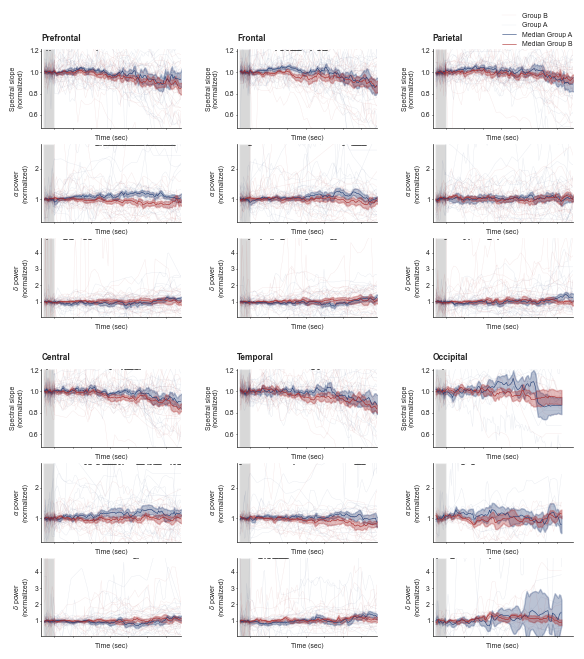

In [399]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.stats import ranksums
from matplotlib.gridspec import GridSpec


# Set the normalization flags
NORMALIZE_AMP = True
NORMALIZE_TIME = True
MIN_ACCEPTABLE_VALUE = 0.01
BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

# BLUE = "#28509C"
# RED = "#C53232"

# Spectral property to analyze
spectral_prop_labels = {
    'reg_fit_slope': 'Spectral slope',
    'fband_power_fooof_alpha': r'$\alpha$ power',
    'fband_power_fooof_delta': r'$\delta$ power'
}

def calculate_normalization_factor(win_center_dic, spectral_prop_dict):
    """
    Calculate normalization factor based on pre_infusion values
    """
    pre_infusion_mean_std = {}
    for p, times in win_center_dic.items():
        times = np.asarray(times).flatten()
        curr_vals_spectral_prop = np.asarray(spectral_prop_dict[p]).flatten()
        if np.sum(curr_vals_spectral_prop) > MIN_ACCEPTABLE_VALUE:  
            pre_infusion_values = curr_vals_spectral_prop[times < 600]
            pre_infusion_mean_std[p] = (np.nanmean(pre_infusion_values), np.nan)
        else:
            pre_infusion_mean_std[p] = (np.nan, np.nan)
            
    return pre_infusion_mean_std

def normalize_time(win_center_dict, spectral_prop_dict, event_time=600):
    """
    Normalize time across patients to the same scale for post-event data,
    while keeping pre-event data unchanged.
    
    Args:
        win_center_dict (dict): Dictionary of time windows per patient.
        spectral_prop_dict (dict): Dictionary of spectral properties per patient.
        event_time (float): The time of the event in seconds (default: 600 seconds).
    
    Returns:
        tuple: Normalized win_center and spectral_prop dictionaries.
    """
    # Determine the number of post-event time points based on the patient with the longest post-event time
    max_patient = max(win_center_dict, key=lambda k: np.sum(np.array(win_center_dict[k]) > event_time))
    num_post_event_points = np.sum(np.array(win_center_dict[max_patient]) > event_time)
    max_post_event_time = win_center_dict[max_patient][-1]
    
    # Create a normalized time scale for the post-event segment
    all_win_centers_post_event = np.linspace(event_time, max_post_event_time, num_post_event_points)

    spectral_prop_normalized_time = {}
    win_center_normalized_time = {}
    
    for p, times in win_center_dict.items():
        times = np.asarray(times).flatten()
        curr_vals_spectral_prop = np.asarray(spectral_prop_dict[p]).flatten()
        
        # Split pre-event and post-event data
        pre_event_mask = times <= event_time
        post_event_mask = times > event_time
        
        pre_event_times = times[pre_event_mask]
        post_event_times = times[post_event_mask]
        
        pre_event_vals = curr_vals_spectral_prop[pre_event_mask]
        post_event_vals = curr_vals_spectral_prop[post_event_mask]
        
        # Interpolate post-event values to match normalized time points
        if len(post_event_times) > 0:
            new_post_event_times = np.linspace(post_event_times[0], post_event_times[-1], num_post_event_points)
            normalized_post_event_vals = np.interp(new_post_event_times, post_event_times, post_event_vals)
        else:
            new_post_event_times = []
            normalized_post_event_vals = []
        
        # Combine pre-event and post-event data
        combined_times = np.concatenate((pre_event_times, all_win_centers_post_event))
        combined_vals = np.concatenate((pre_event_vals, normalized_post_event_vals))
        
        win_center_normalized_time[p] = combined_times
        spectral_prop_normalized_time[p] = combined_vals

    return win_center_normalized_time, spectral_prop_normalized_time

# def normalize_time(win_center_dict, spectral_prop_dict):
#     """
#     Normalize time across patients to the same scale
#     """
#     max_patient = max(win_center_dict, key=lambda k: len(win_center_dict[k]))
#     num_time_points = len(win_center_dict[max_patient])
#     max_time = win_center_dict[max_patient][-1]
#     all_win_centers = np.linspace(0, max_time, num_time_points)

#     spectral_prop_normalized_time = {}
#     win_center_normalized_time = {}
#     for p, times in win_center_dict.items():
#         times = np.asarray(times).flatten()
#         curr_vals_spectral_prop = np.asarray(spectral_prop_dict[p]).flatten()
        
#         # Interpolate curr_vals_spectral_prop to match the new time points
#         new_times = np.linspace(times[0], times[-1], num_time_points)
#         win_center_normalized_time[p] = all_win_centers
#         spectral_prop_normalized_time[p] = np.interp(new_times, times, curr_vals_spectral_prop)

#     return win_center_normalized_time, spectral_prop_normalized_time

def bootstrap_sem(data, num_bootstrap=1000, axis=0):
    n = data.shape[1]
    boot_medians = np.zeros((num_bootstrap, n))
    for i in range(num_bootstrap):
        samples = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
        boot_medians[i, :] = np.nanmedian(data[samples, :], axis=axis)
    return np.nanstd(boot_medians, axis=0, ddof=1)

def align_and_average(win_center_dict, spectral_prop_dict, normalize_factor):

    all_win_centers = sorted(set().union(*win_center_dict.values()))
        
    avg_dict = {}
    for p, times in win_center_dict.items():
        try:
            times = np.asarray(times).flatten()
            curr_vals_spectral_prop = np.asarray(spectral_prop_dict[p]).flatten()
            if np.sum(curr_vals_spectral_prop) > MIN_ACCEPTABLE_VALUE:  # Ensure the current values of the spectral prop are not entirely zero

                interpolated_spectral_prop_values = np.interp(all_win_centers, times, curr_vals_spectral_prop)
                interpolated_spectral_prop_values[all_win_centers > times[-1]] = np.nan
                
                if NORMALIZE_AMP:
                    mean, _ = normalize_factor[p]
                    interpolated_spectral_prop_values = interpolated_spectral_prop_values / mean
                    
                avg_dict[p] = interpolated_spectral_prop_values
        except Exception as e:
            warnings.warn(f"Warning: An error occurred while aligning and averaging for patient {p}: {e}", UserWarning)
    
    # Stack all patient data together
    data = np.vstack(list(avg_dict.values()))
    
    # Non-parametric median
    median_all = np.nanmedian(data, axis=0)
    
    # Bootstrapped SEM
    sem_all = bootstrap_sem(data, axis=0)
    
    return np.array(all_win_centers), median_all, sem_all

def flatten_and_filter(data):
    flatten_data = []
    for sublist in data:
        if isinstance(sublist, (list, np.ndarray)):
            for item in sublist:
                if item is not None: 
                    flatten_data.append(item)
        elif isinstance(sublist, (float, int, np.float64, np.int64)):  
            flatten_data.append(sublist)
    return flatten_data

def z_score(data, mean_std):
    mean, std = mean_std
    return (data - mean) / std

def apply_normalization(data, mean_std):
    if NORMALIZE_AMP:
        mean, _ = mean_std
        return data / mean
    return data


# Calculate the y-axis lower and upper bound for the plots
win_center_emergence_all_regions = {}
spectral_prop_time_course_emergence_all_regions = {}
norm_spectral_prop_values_all_regions = {}

# Y-axis bounds
ylim_lower_bound = {}
ylim_upper_bound = {}

for spectral_prop_name in spectral_prop_labels:
    spectral_prop = patients_pooled_data[spectral_prop_name]

    win_center_emergence_all_regions[spectral_prop_name] = {}
    spectral_prop_time_course_emergence_all_regions[spectral_prop_name] = {}
    norm_spectral_prop_values_all_regions[spectral_prop_name] = {}
    
    region_ylim = {}
    for region in region_names:
         
        win_center_emergence = {
            p: win_center[p][region]['emergence']
            for p in win_center
            if np.sum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE
        }

        spectral_prop_time_course_emergence = {
            p: spectral_prop[p][region]['emergence']
            for p in spectral_prop
            if np.sum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE
        }
        if NORMALIZE_TIME:
            win_center_emergence, spectral_prop_time_course_emergence = normalize_time(
                win_center_emergence, spectral_prop_time_course_emergence
            )

        # Calculate normalization factor for each patient
        normalize_factor = calculate_normalization_factor(win_center_emergence, spectral_prop_time_course_emergence)
        norm_spectral_prop_values = {
            p: apply_normalization(
                spectral_prop_time_course_emergence[p],
                normalize_factor[p]
            )
            for p in win_center_emergence
        }
        # Calculate region bounds
        # all_spectral_prop_vals = np.vstack(list(norm_spectral_prop_values.values())).flatten()
        # region_ylim[region] = [np.nanpercentile(all_spectral_prop_vals, 5), np.nanpercentile(all_spectral_prop_vals, 95)]

        all_spectral_prop_vals = np.concatenate([np.asarray(vals).flatten() for vals in norm_spectral_prop_values.values()])
        region_ylim[region] = [np.nanpercentile(all_spectral_prop_vals, 5), np.nanpercentile(all_spectral_prop_vals, 95)]
        
        win_center_emergence_all_regions[spectral_prop_name][region] = win_center_emergence
        spectral_prop_time_course_emergence_all_regions[spectral_prop_name][region] = spectral_prop_time_course_emergence
        norm_spectral_prop_values_all_regions[spectral_prop_name][region] = norm_spectral_prop_values
        
    ylims_all_regions = np.vstack(list(region_ylim.values()))
    ylim_lower_bound[spectral_prop_name] = np.nanmin(ylims_all_regions[:, 0])
    ylim_upper_bound[spectral_prop_name] = np.nanmax(ylims_all_regions[:, 1])



# Define figure properties
ncols = 3
nrows = int(np.ceil(len(region_names) / ncols)) * (len(spectral_prop_labels)+1)
plot_width = 170 * ncols 
plot_height = 70 * nrows

set_custom_style()  # Assuming this is defined separately

fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(plot_width / 72, plot_height / 72), 
    sharex=True, 
    height_ratios=[1,1,1,0.25,1,1,1,0.25]
)
axs = axs.flatten()  # Flatten the axes for easier indexing

# Loop over each region to plot emergence data
for region_idx, region in enumerate(region_names):
    for sp_idx, spectral_prop_name in enumerate(spectral_prop_labels):
        
        col = region_idx % ncols  # Column index
        row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + sp_idx   # Row index
        curr_ax = axs[row * ncols + col]  # Access the subplot
        
        win_center_emergence = win_center_emergence_all_regions[spectral_prop_name][region]
        spectral_prop_time_course_emergence = spectral_prop_time_course_emergence_all_regions[spectral_prop_name][region]
        
        # Calculate normalization factor for each patient
        normalize_factor = calculate_normalization_factor(win_center_emergence, spectral_prop_time_course_emergence)
        
        # Plot emergence line plots
        for p in win_center_emergence:
            times = np.asarray(win_center_emergence[p]).flatten()            
            curr_norm_spectral_prop_values = norm_spectral_prop_values_all_regions[spectral_prop_name][region][p]
            if group_label[p] == 'A':
                curr_ax.plot(times - 600, curr_norm_spectral_prop_values, '-', color=BLUE, label='Group A' if 'Group A' not in curr_ax.get_legend_handles_labels()[1] else "", linewidth=0.3, alpha=0.1)
            elif group_label[p] == 'B':
                curr_ax.plot(times - 600, curr_norm_spectral_prop_values, '-', color=RED, label='Group B' if 'Group B' not in curr_ax.get_legend_handles_labels()[1] else "", linewidth=0.3, alpha=0.1)

        # Split data by group
        groupA_win_centers = {p: win_center_emergence[p] for p in group_label if group_label[p] == 'A' and p in win_center_emergence}
        groupB_win_centers = {p: win_center_emergence[p] for p in group_label if group_label[p] == 'B' and p in win_center_emergence}
        groupA_spectral_prop_data = {p: spectral_prop_time_course_emergence[p] for p in group_label if group_label[p] == 'A' and p in spectral_prop_time_course_emergence}
        groupB_spectral_prop_data = {p: spectral_prop_time_course_emergence[p] for p in group_label if group_label[p] == 'B' and p in spectral_prop_time_course_emergence}

        avg_win_centers_A, median_spectral_prop_groupA, sem_spectral_prop_groupA = align_and_average(groupA_win_centers, groupA_spectral_prop_data, normalize_factor)
        avg_win_centers_B, median_spectral_prop_gourpB, sem_spectral_prop_groupB = align_and_average(groupB_win_centers, groupB_spectral_prop_data, normalize_factor)

        # Plot averages with SEM
        curr_ax.plot(avg_win_centers_A - 600, median_spectral_prop_groupA, '-', color=BLUE, linewidth=0.4, label='Median Group A')
        curr_ax.fill_between(avg_win_centers_A - 600, median_spectral_prop_groupA - sem_spectral_prop_groupA, median_spectral_prop_groupA + sem_spectral_prop_groupA, color=BLUE, alpha=0.3)
        
        curr_ax.plot(avg_win_centers_B - 600, median_spectral_prop_gourpB, '-', color=RED, linewidth=0.4, label='Median Group B')
        curr_ax.fill_between(avg_win_centers_B - 600, median_spectral_prop_gourpB - sem_spectral_prop_groupB, median_spectral_prop_gourpB + sem_spectral_prop_groupB, color=RED, alpha=0.3)
        
        if sp_idx == 0:
            curr_ax.set_title(f"{region.capitalize()}", loc='left', fontweight='bold')
        
        if NORMALIZE_AMP:
            curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(normalized)')
        else:
            if spectral_prop_name == 'reg_fit_slope':
                curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(dB/Hz)')
            else:
                curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(dB)')

        curr_ax.set_xticks(np.arange(0, win_center_emergence['CA-01'][-1], 1000))
        curr_ax.set_xlabel('Time (sec)')

        if region_idx == 0:
            ax_legend = fig.add_subplot([0.7, 0.9, 0.1, 0.05])
            legend_lines, legend_labels = curr_ax.get_legend_handles_labels()
            ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5)
            ax_legend.spines['bottom'].set_visible(False)
            ax_legend.spines['left'].set_visible(False)
            ax_legend.set_xticks([])
            ax_legend.set_yticks([])
            ax_legend.tick_params(bottom=False, left=False)
            ax_legend.set_facecolor('none')

        # curr_ax.set_ylim([0, 0.5])
        # curr_ax.set_ylim([0, 2]) # alpha power

        curr_ax.set_ylim([ylim_lower_bound[spectral_prop_name], ylim_upper_bound[spectral_prop_name]])
        curr_ax.set_xlim([-700, win_center_emergence['CA-01'][-1]])

        if NORMALIZE_AMP:
            start_time = -600
            end_time = 0
            yl = curr_ax.get_ylim()
            rect = Rectangle((start_time, yl[0]), end_time - start_time, yl[1]-yl[0], facecolor='gray', alpha=0.3)
            curr_ax.add_patch(rect)

        curr_ax.spines['top'].set_visible(False)
        curr_ax.spines['right'].set_visible(False)
        
        # Perform ranksum test for each time point and add significance asterisks
        significance_line_y=0.99 * (ylim_upper_bound[spectral_prop_name] - ylim_lower_bound[spectral_prop_name]) + ylim_lower_bound[spectral_prop_name]
        diff_time = avg_win_centers_A[1] - avg_win_centers_A[0]
        for i, time_point in enumerate(avg_win_centers_A):
            groupA_at_time = [apply_normalization(spectral_prop_time_course_emergence[p][np.argmin(np.abs(win_center_emergence[p] - time_point))], normalize_factor[p]) for p in groupA_win_centers if time_point in win_center_emergence[p]]
            groupB_at_time = [apply_normalization(spectral_prop_time_course_emergence[p][np.argmin(np.abs(win_center_emergence[p] - time_point))], normalize_factor[p]) for p in groupB_win_centers if time_point in win_center_emergence[p]]
            if groupA_at_time and groupB_at_time:
                p_value = ranksums(groupA_at_time, groupB_at_time).pvalue
                if p_value < 0.05:
                    curr_ax.plot([time_point-600-(diff_time/2), time_point-600+(diff_time/2)], [significance_line_y, significance_line_y], color='k', lw=0.5)
    
    if region_idx == 0:
        ax_legend = fig.add_subplot([0.8, 0.9, 0.1, 0.05])
        legend_lines, legend_labels = curr_ax.get_legend_handles_labels()
        ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5)
        ax_legend.spines['bottom'].set_visible(False)
        ax_legend.spines['left'].set_visible(False)
        ax_legend.set_xticks([])
        ax_legend.set_yticks([])
        ax_legend.tick_params(bottom=False, left=False)
        ax_legend.set_facecolor('none')

    row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + len(spectral_prop_labels) # Row index
    curr_ax = axs[row * ncols + col]  # Access the subplot
    curr_ax.remove()


plt.tight_layout()
plt.subplots_adjust(left=0.15, right= 0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.25)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'

filename = 'emergence_trajectory_groupA_vs_groupB'
if NORMALIZE_AMP:
    filename += '_normalized_to_pre_infusion'
if NORMALIZE_TIME:
    filename += '_time_normalized'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()


##### Plot PSDs without any normalization for the pre_drug_infusion and each emergence quartile 
* This can come before the above analysis to give us a hint about the shape of the power spectral densities without any further processings 

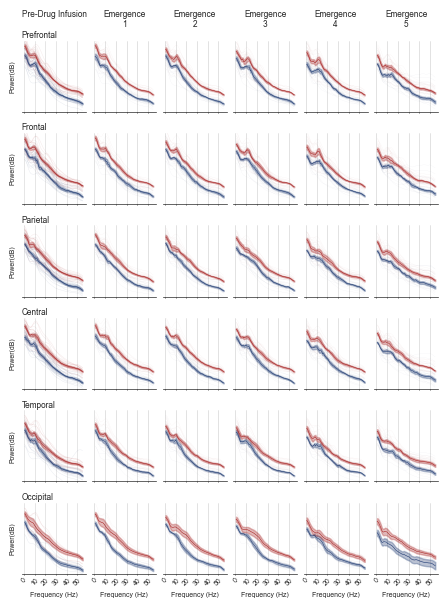

In [456]:
# Function to calculate quartiles
def cal_psd_quartiles(psd_dict, times_dict, num_quartiles=4, start_time=600):
    pre_drug_infusion_psds = {}
    emergence_quartile_psds = {}
    for p, psds in psd_dict.items():
        times = np.asarray(times_dict[p])

        # Processing pre drug infusion PSDs
        pre_drug_psds = psds[:, times < start_time, 0]
        pre_drug_psds[pre_drug_psds == 0] = 1e-16
        pre_drug_psds = 10*np.log10(pre_drug_psds)

        pre_drug_infusion_psds[p] = np.nanmedian(pre_drug_psds, axis=1)

        # Processing emergence PSDs
        emergence_psds = psds[:, times > start_time, 0]
        emergence_psds[emergence_psds == 0] = 1e-16
        emergence_psds = 10*np.log10(emergence_psds)

        if len(emergence_psds) >= num_quartiles:
            quartiles = np.array_split(emergence_psds, num_quartiles, axis=1)
            emergence_quartile_psds[p] = [np.nanmedian(q, axis=1) for q in quartiles]
        else:
            emergence_quartile_psds[p] = [np.nan] * num_quartiles
    
    # Calculating the median and sem of PSD across all patients
    # Pre-drug infusion
    pre_drug_data = np.vstack(list(pre_drug_infusion_psds.values()))
    pre_drug_median_psd = np.nanmedian(pre_drug_data, axis=0)
    pre_drug_sem_psd = bootstrap_sem(pre_drug_data, num_bootstrap=1000, axis=0)

    emergence_quartile_median_psd = [None] * num_quartiles
    emergence_quartile_sem_psd = [None] * num_quartiles
    for q in range(num_quartiles):
        quartile_data = np.vstack([emergence_quartile_psds[p][q] for p in emergence_quartile_psds])
        emergence_quartile_median_psd[q] = np.nanmedian(quartile_data, axis=0)
        emergence_quartile_sem_psd[q] = bootstrap_sem(quartile_data, num_bootstrap=1000, axis=0)

    return (
        pre_drug_infusion_psds, pre_drug_median_psd, pre_drug_sem_psd,
        emergence_quartile_psds, emergence_quartile_median_psd, emergence_quartile_sem_psd
    )

freqs = loaded_power_spectral.frequencies
num_emergence_divisions = 5
BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

# Create a new figure for violin plots
plot_width = 80*num_emergence_divisions
plot_height = 80 * len(region_names)
fig, axs = plt.subplots(len(region_names), 1+num_emergence_divisions, figsize=(plot_width/72, plot_height/72))

psd = patients_pooled_data['psd']
yl = [0, 55]
shift = 8

for region_idx, region in enumerate(region_names):
    win_center_emergence = {p: win_center[p][region]['emergence'] for p in win_center if np.sum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE}
    psd_emergence = {p: psd[p][region]['emergence'] for p in psd if np.sum(psd[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE}

    # Calculate quartile data
    (pre_drug_psds_A, pre_drug_median_psd_A, pre_drug_sem_psd_A, 
    emergence_quartile_psds_A, emergence_quartile_median_psd_A, emergence_quartile_sem_psd_A
    ) = cal_psd_quartiles(
        {p: psd_emergence[p] for p in group_label if group_label[p] == 'A' and p in psd_emergence},
        win_center_emergence,
        num_quartiles=num_emergence_divisions
    )

    (pre_drug_psds_B, pre_drug_median_psd_B, pre_drug_sem_psd_B, 
    emergence_quartile_psds_B, emergence_quartile_median_psd_B, emergence_quartile_sem_psd_B
    ) = cal_psd_quartiles(
        {p: psd_emergence[p] for p in group_label if group_label[p] == 'B' and p in psd_emergence},
        win_center_emergence,
        num_quartiles=num_emergence_divisions,
    )

    # Plot the pre-drug infusion PSDs for groups A and B
    ax = axs[region_idx, 0]

    # group A:
    for p, p_psd in pre_drug_psds_A.items():
        ax.plot(freqs, p_psd, BLUE, alpha=0.1, linewidth=0.3, label= 'Group A')

    # group B:
    for p, p_psd in pre_drug_psds_B.items():
        ax.plot(freqs, p_psd + shift, RED, alpha=0.1, linewidth=0.3, label= 'Group B')
    
    ax.plot(freqs, pre_drug_median_psd_A, BLUE, linewidth=0.4, label='Median Group A')
    ax.fill_between(freqs, pre_drug_median_psd_A - pre_drug_sem_psd_A, pre_drug_median_psd_A + pre_drug_sem_psd_A, color=BLUE, alpha=0.3)

    ax.plot(freqs, pre_drug_median_psd_B+shift, RED, linewidth=0.4, label='Median Group B')
    ax.fill_between(freqs, pre_drug_median_psd_B - pre_drug_sem_psd_B + shift, pre_drug_median_psd_B + pre_drug_sem_psd_B + shift, color=RED, alpha=0.3)
    
    ax.set_xticks(np.arange(0, 55, 10))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    if region_idx != 5:
        ax.set_xticklabels('')

    ax.set_ylim(yl)
    ax.set_yticks(np.arange(yl[0], yl[1], 10))
    if region_idx == 0:
        ax.set_title(f'Pre-Drug Infusion\n \n{region.capitalize()}', va = 'bottom', ha = 'left', loc='left', y=0.9)
    else:
        ax.set_title(f'{region.capitalize()}', va = 'bottom', ha = 'left', loc = 'left', y=0.9)
    
    if region_idx== 5:
        ax.set_xlabel('Frequency (Hz)')
    
    ax.set_ylabel('Power(dB)')

    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks([])
    ax.grid(axis='x', linestyle='-', alpha=0.7, linewidth=0.5)  # Add x-grid only


    # Plot the emergence PSDs for groups A and B
    for q in range(num_emergence_divisions):
        ax = axs[region_idx, q+1]

        # group A
        for p, p_psd in emergence_quartile_psds_A.items():
            ax.plot(freqs, p_psd[q], BLUE, alpha=0.1, linewidth=0.1, label= 'Group A')

        # group B
        for p, p_psd in emergence_quartile_psds_B.items():
            ax.plot(freqs, p_psd[q] + shift, RED, alpha=0.1, linewidth=0.1, label = 'Group B')

        ax.plot(freqs, emergence_quartile_median_psd_A[q], BLUE, linewidth=0.4, label='Median Group A')
        ax.fill_between(freqs, emergence_quartile_median_psd_A[q] - emergence_quartile_sem_psd_A[q], emergence_quartile_median_psd_A[q] + emergence_quartile_sem_psd_A[q], color=BLUE, alpha=0.3)

        ax.plot(freqs, emergence_quartile_median_psd_B[q] + shift, RED, linewidth=0.4, label='Median Group B')
        ax.fill_between(freqs, emergence_quartile_median_psd_B[q] - emergence_quartile_sem_psd_B[q] + shift, emergence_quartile_median_psd_B[q] + emergence_quartile_sem_psd_B[q] + shift, color=RED, alpha=0.3)

        ax.set_xticks(np.arange(0, 55, 10))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
        if region_idx != 5:
            ax.set_xticklabels('')

        ax.set_ylim(yl)
        ax.set_yticks(np.arange(yl[0], yl[1], 10))    
        if region_idx== 5:
            ax.set_xlabel('Frequency (Hz)')    
        ax.set_yticklabels("")

        if region_idx == 0:
            ax.set_title(f'Emergence\n{q+1}\n ', va = 'bottom', ha = 'center', loc='center', y=0.9)

        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks([])

        ax.grid(axis='x', linestyle='-', alpha=0.8, linewidth=0.5)  # Add x-grid only

        if region_idx == 0 and q == num_emergence_divisions:
            ax_legend = fig.add_subplot([0.8, 0.9, 0.1, 0.05])
            legend_lines, legend_labels = ax.get_legend_handles_labels()
            ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5)
            ax_legend.spines['bottom'].set_visible(False)
            ax_legend.spines['left'].set_visible(False)
            ax_legend.set_xticks([])
            ax_legend.set_yticks([])
            ax_legend.tick_params(bottom=False, left=False)
            ax_legend.set_facecolor('none')


plt.tight_layout()
plt.subplots_adjust(left=0.15, right= 0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.3)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'

filename = 'PSDs_emergence_quartiles_groupA_vs_groupB'
if NORMALIZE_AMP:
    filename += '_normalized_to_pre_infusion'
if NORMALIZE_TIME:
    filename += '_time_normalized'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Generate the violinplots corresponding to emergence quartiles 

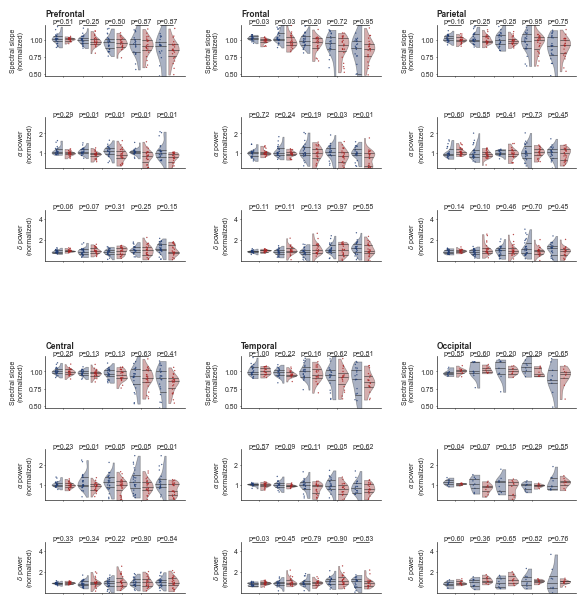

In [ ]:
NORMALIZE_AMP = True
# Function to calculate quartiles
def calculate_quartiles(data_dict, times_dict, start_time=600):
    quartile_data = {}
    for p, data in data_dict.items():
        times = np.asarray(times_dict[p])
        relevant_data = data[times > start_time]
        relevant_data = apply_normalization(relevant_data, normalize_factor[p])
        num_quartiles = num_emergence_divisions
        if len(relevant_data) >= num_quartiles:
            quartiles = np.array_split(relevant_data, num_quartiles)
            quartile_avg = [np.nanmean(q) for q in quartiles]
        else:
            quartile_avg = [np.nan] * num_quartiles
        quartile_data[p] = quartile_avg
    return quartile_data

def remove_outliers(data, method='iqr', threshold=1.5):
    """
    Remove outliers from a list of data using the specified method.
    Supports 'iqr' (Interquartile Range) or 'std' (Standard Deviation).
    """
    data = np.array(data)
    if method == 'iqr':
        # IQR method
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
    elif method == 'std':
        # Standard Deviation method
        mean = np.mean(data)
        std_dev = np.std(data)
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
    else:
        raise ValueError("Invalid method. Choose 'iqr' or 'std'.")
    
    # Filter data
    return data[(data >= lower_bound) & (data <= upper_bound)]


num_emergence_divisions = 5

# # Create a new figure for violin plots
# plot_width = 200
# plot_height = 100 * len(region_names)
# fig_violin, axs = plt.subplots(len(region_names), 3, figsize=(plot_width / 72, plot_height / 72), gridspec_kw={'width_ratios': [0.2, 1, 0.2]})


# Define figure properties
ncols = 3
nrows = int(np.ceil(len(region_names) / ncols)) * (len(spectral_prop_labels)+1)
plot_width = 170 * ncols 
plot_height = 70 * nrows

set_custom_style()  # Assuming this is defined separately

fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(plot_width / 72, plot_height / 72), 
    sharex=True, 
    height_ratios=[1,1,1,0.25,1,1,1,0.25]
)
axs = axs.flatten()  # Flatten the axes for easier indexing

# Loop over each region for violin plots
for region_idx, region in enumerate(region_names): 
    for sp_idx, spectral_prop_name in enumerate(spectral_prop_labels):

        # print(spectral_prop_name)

        col = region_idx % ncols  # Column index
        row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + sp_idx   # Row index
        curr_ax = axs[row * ncols + col]  # Access the subplot
        
        win_center_emergence = win_center_emergence_all_regions[spectral_prop_name][region]
        spectral_prop_time_course_emergence = spectral_prop_time_course_emergence_all_regions[spectral_prop_name][region]
        
        # Calculate normalization factor for each patient
        normalize_factor = calculate_normalization_factor(win_center_emergence, spectral_prop_time_course_emergence)
        
        # Calculate quartile data
        quartile_data_A = calculate_quartiles({p: spectral_prop_time_course_emergence[p] for p in group_label if group_label[p] == 'A' and p in spectral_prop_time_course_emergence}, win_center_emergence)
        quartile_data_B = calculate_quartiles({p: spectral_prop_time_course_emergence[p] for p in group_label if group_label[p] == 'B' and p in spectral_prop_time_course_emergence}, win_center_emergence)

        # Combine data so the order is Q1 A and B, Q2 A and B, etc.
        combined_quartiles = []
        colors = []
        for q in range(num_emergence_divisions):
            quartile_A = [quartile_data_A[p][q] for p in quartile_data_A]
            quartile_B = [quartile_data_B[p][q] for p in quartile_data_B]
            quartile_A = remove_outliers(quartile_A)
            quartile_B = remove_outliers(quartile_B)
            combined_quartiles.append(quartile_A)
            combined_quartiles.append(quartile_B)
            colors.extend([BLUE, RED])
          
        # Plot quartile emergence data
        # curr_ax = axs[idx, 1]
        sns.violinplot(data=combined_quartiles, ax=curr_ax, cut=0, inner='quart', density_norm='area', palette=colors, linewidth=0.5, alpha=0.4, split=True)
        sns.stripplot(data=combined_quartiles, ax=curr_ax, jitter=True, edgecolor='auto', size=1, palette=colors, alpha=0.8)
        curr_ax.set_xticks(np.arange(0.5, 8, 1.5))

        if sp_idx == len(spectral_prop_labels)-2:
            curr_ax.set_xticklabels([f'E{i+1}' for i in range(num_emergence_divisions)])

        for line in curr_ax.lines:
            line.set_linestyle('-')
            line.set_linewidth(0.4)

        if sp_idx == 0:
            curr_ax.set_title(f"{region.capitalize()}", loc='left', fontweight='bold')

        if NORMALIZE_AMP:
            curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(normalized)')
        else:
            if spectral_prop_name == 'reg_fit_slope':
                curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(dB/Hz)')
            else:
                curr_ax.set_ylabel(f'{spectral_prop_labels[spectral_prop_name]}\n(dB)')

        curr_ax.set_ylim([ylim_lower_bound[spectral_prop_name], ylim_upper_bound[spectral_prop_name]])

        # Perform ranksum test and add significance line for each quartile
        significance_line_y=1 * (ylim_upper_bound[spectral_prop_name] - ylim_lower_bound[spectral_prop_name]) + ylim_lower_bound[spectral_prop_name]
        for i in range(num_emergence_divisions):
            quartile_A = [quartile_data_A[p][i] for p in quartile_data_A]
            quartile_B = [quartile_data_B[p][i] for p in quartile_data_B]
            try:
                p_value_quartile = ranksums(quartile_A, quartile_B).pvalue
                curr_ax.plot([i * 2, (i * 2) + 1], [significance_line_y, significance_line_y], color='k', lw=0.5)
                curr_ax.text(i * 2 + 0.5, significance_line_y * 1.02, f'p={p_value_quartile:.2f}', ha='center', fontsize=5)
            except ValueError:
                continue

    row = (region_idx // ncols) * (len(spectral_prop_labels)+1) + len(spectral_prop_labels) # Row index
    curr_ax = axs[row * ncols + col]  # Access the subplot
    curr_ax.remove()

        
plt.tight_layout()
plt.subplots_adjust(left=0.15, right= 0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=1)

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = f'violinplots_emergence_quartiles_groupA_vs_groupB'
if NORMALIZE_AMP:
    filename += '_normalized_to_pre_infusion'
# if NORMALIZE_TIME:
#     filename += '_time_normalized'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Plot raw power spectral densities
By raw, I mean we are not doing any normalization to to the pre-drung infusion period. 

In [ ]:
# TODO: Maybe only during the preop and PACU rest epochs

#### Calculate and plot the decay time constants 

In [ ]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit, OptimizeWarning
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from numpy.linalg import LinAlgError

# Function to smooth the data
def smooth_data(data, polyorder=3):
    try:
        if len(data) < 3 or np.isnan(data).any():
            return data  # Not enough data points to smooth, return as is
        window_length = min(51, len(data) if len(data) % 2 == 1 else len(data) - 1)
        return savgol_filter(data, window_length=window_length, polyorder=polyorder, mode='interp')
    except (LinAlgError, ValueError):
        return data  # Return the data as is if smoothing fails

# Exponential decay model function
def exponential_decay(t, a, b):
    return a * np.exp(-b * t)

# Function to calculate the decay time constant
def calculate_decay_time_constant(times, data, max_value, threshold):
    decay_threshold = max_value * threshold

    # Find the point where the data first drops below the decay threshold
    decay_points = times[data < decay_threshold]
    
    if len(decay_points) == 0:
        decay_index = len(times) - 1  # Use the last time point if there's no decay below the threshold
    else:
        decay_index = np.where(times == decay_points[0])[0][0]

    if decay_index == 0 or len(data[:decay_index]) < 2:
        return np.nan  # Not enough data points to fit a reliable curve

    try:
        # Fit the exponential decay model on the data till that point
        popt, _ = curve_fit(exponential_decay, times[:decay_index], data[:decay_index], p0=(max_value, 0.01))
        return 1 / popt[1]
    except (RuntimeError, OptimizeWarning):
        return np.nan  # Handle cases where the fit fails

# Normalization functions
def calculate_normalization_factors(win_center_dic, slope_dict):
    mean_std_600 = {}
    for p, times in win_center_dic.items():
        times = np.asarray(times).flatten()
        slopes = np.asarray(slope_dict[p]).flatten()
        if np.sum(slopes) > MIN_ACCEPTABLE_VALUE:
            slopes_less_600 = slopes[times < 600]
            mean_std_600[p] = (np.nanmean(slopes_less_600), np.nanstd(slopes_less_600), np.nanmean(slopes_less_600))
        else:
            mean_std_600[p] = (np.nan, np.nan, np.nan)
    return mean_std_600

def z_score(data, mean_std):
    mean, std = mean_std[:2]
    return (data - mean) / std

# Set the normalization flag
NORMALIZE = True

# Number of regions for plotting
num_regions = len(region_names)
fig, axes = plt.subplots(nrows=num_regions, figsize=(10, 5*num_regions))

if num_regions == 1:
    axes = [axes]  # Make axes iterable if there's only one region

for i, region in enumerate(region_names):
    win_center_emergence = {p: win_center[p][region]['emergence'] for p in win_center if np.sum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE}
    reg_fit_slope_emergence = {p: spectral_prop[p][region]['emergence'] for p in spectral_prop if np.sum(spectral_prop[p][region]['emergence']) > MIN_ACCEPTABLE_VALUE}

    # Calculate normalization factor for each patient
    mean_std_600 = calculate_normalization_factors(win_center_emergence, reg_fit_slope_emergence)

    groupA_decay_constants = []
    groupB_decay_constants = []

    decay_threshold = 0.37

    for p in win_center_emergence:
        times = np.asarray(win_center_emergence[p]).flatten()
        slopes = np.asarray(reg_fit_slope_emergence[p]).flatten()
        
        if slopes.size == 0 or times.size == 0:
            decay_constant = np.nan
        else:
            normalized_slopes = z_score(slopes, mean_std_600[p])
            smoothed_slopes = smooth_data(normalized_slopes)
            mean_value = mean_std_600[p][2]
            decay_constant = calculate_decay_time_constant(times-600, smoothed_slopes, mean_value, decay_threshold)
        
        if group_label[p] == 'A':
            groupA_decay_constants.append(decay_constant)
        elif group_label[p] == 'B':
            groupB_decay_constants.append(decay_constant)
    
    decay_constants_flat_A = [item for item in groupA_decay_constants if not np.isnan(item)]
    decay_constants_flat_B = [item for item in groupB_decay_constants if not np.isnan(item)]

    ax = axes[i]

    sns.violinplot(data=[decay_constants_flat_A, decay_constants_flat_B], cut=0, inner='quart', palette=["#1f3b73", "#a82323"], ax=ax)
    sns.stripplot(data=[decay_constants_flat_A, decay_constants_flat_B], jitter=True, edgecolor='auto', size=5, palette=["#1f3b73", "#a82323"], ax=ax)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Group A', 'Group B'], rotation=45)
    ax.set_title(f'Decay Time Constants for {region}')
    ax.set_ylabel('Time Constant (s)')
    ax.set_ylim(bottom=0)  # Assuming no negative time constants

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import wilcoxon

# orange = "#ff7f0e"
green = "#228B22"
purple = "#9467bd"
gray = "#535353"  # Gray Color for Violin Plots

fregs = loaded_power_spectral.frequencies

def extract_psds_spectral_prop(region):
    preop_psds = {}
    emergence_psds = {}
    pacu_psds = {}
    preop_spectral_prop = {}
    emergence_spectral_prop = {}
    pacu_spectral_prop = {}
    for p in win_center:
        # Group A or B
        if group_label[p] == 'A' or group_label[p] == 'B':
            
            # Extracting and processing PSDs
            preop_psd = psd[p][region]['preop_rest'].flatten()
            pacu_psd = psd[p][region]['pacu_rest'].flatten()
            maintenance_psd = np.nanmean(psd[p][region]['emergence'], axis=1).flatten()

            preop_psd = preop_psd/np.nansum(preop_psd)
            pacu_psd = pacu_psd/np.nansum(pacu_psd)
            maintenance_psd = maintenance_psd/np.nansum(maintenance_psd)

            preop_psd[preop_psd == 0] = 1e-16
            pacu_psd[pacu_psd == 0] = 1e-16
            maintenance_psd[maintenance_psd == 0] = 1e-16

            preop_psd = 10*np.log10(preop_psd)
            pacu_psd = 10*np.log10(pacu_psd)
            maintenance_psd = 10*np.log10(maintenance_psd)

            # Extracting the spectral prop extracted from the PSDs
            preop_prop = spectral_prop[p][region]['preop_rest']
            emergence_prop = spectral_prop[p][region]['emergence'][0]
            pacu_prop = spectral_prop[p][region]['pacu_rest']

            if (not np.isnan(preop_psd).any() and not np.isnan(pacu_psd).any() and not np.isnan(maintenance_psd).any() and
                preop_prop > 0.01 and pacu_prop > 0.01 and emergence_prop > 0.01):
                
                # Stroing PSD data
                preop_psds[p] = preop_psd
                emergence_psds[p] = maintenance_psd
                pacu_psds[p] = pacu_psd

                # Storing Spectral porp data
                preop_spectral_prop[p] = preop_prop
                emergence_spectral_prop[p] = emergence_prop
                pacu_spectral_prop[p] = pacu_prop

    # Processing PSD data
    preop_data = np.vstack(list(preop_psds.values()))
    preop_med_psd = np.nanmedian(preop_data, axis=0)
    preop_sem_psd = bootstrap_sem(preop_data)

    emergence_data = np.vstack(list(emergence_psds.values()))
    emergence_med_psd = np.nanmedian(emergence_data, axis=0)
    emergence_sem_psd = bootstrap_sem(emergence_data)

    pacu_data = np.vstack(list(pacu_psds.values()))
    pacu_med_psd = np.nanmedian(pacu_data, axis=0)
    pacu_sem_psd = bootstrap_sem(pacu_data)

    return (
        preop_psds, preop_med_psd, preop_sem_psd, preop_spectral_prop,
        emergence_psds, emergence_med_psd, emergence_sem_psd, emergence_spectral_prop,
        pacu_psds, pacu_med_psd, pacu_sem_psd, pacu_spectral_prop
    )

# Define figure properties
set_custom_style()

plot_width = 50 * len(region_names)
plot_height = 200

fig, axs = plt.subplots(2, len(region_names), figsize=(plot_width/72 , plot_height/72))

# Loop over each region
for i, region in enumerate(region_names):

    (preop_psds, preop_med_psd, preop_sem_psd, preop_spectral_prop_dict,   
    emergence_psds, emergence_med_psd, emergence_sem_psd, emergence_spectral_prop_dict, 
    pacu_psds, pacu_med_psd, pacu_sem_psd, pacu_spectral_prop_dict) = extract_psds_spectral_prop(region)

    # preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop = extract_spectral_prop(region)

    # Plot the PSDs
    ax = axs[0, i]
    
    for p, p_psd in preop_psds.items():
        ax.plot(fregs, p_psd+6, green, alpha=0.1, linewidth = 0.3)
    ax.plot(fregs, preop_med_psd+6, green, linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, preop_med_psd - preop_sem_psd + 6, preop_med_psd + preop_sem_psd + 6, color=green, alpha=0.5)

    # ax.plot(preop_med_psd - preop_sem_psd, green, linewidth=0.3, linestyle='--', alpha=0.7)
    # ax.plot(preop_med_psd + preop_sem_psd, green, linewidth = 0.3,linestyle='--', alpha=0.7)
    
    for p, p_psd in emergence_psds.items():
        ax.plot(fregs, p_psd, 'k', alpha=0.1, linewidth = 0.3)
    ax.plot(fregs, emergence_med_psd, 'k', linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, emergence_med_psd - emergence_sem_psd, emergence_med_psd + emergence_sem_psd, color='k', alpha=0.5)

    # ax.plot(emergence_med_psd - emergence_sem_psd, 'k', linewidth=0.3, linestyle='--', alpha=0.7)
    # ax.plot(emergence_med_psd + emergence_sem_psd, 'k', linewidth = 0.3,linestyle='--', alpha=0.7)

    for p, p_psd in pacu_psds.items():
        ax.plot(fregs, p_psd - 6, purple, alpha=0.1, linewidth = 0.3)
    ax.plot(fregs, pacu_med_psd - 6, purple, linewidth=0.3, alpha=0.7)
    ax.fill_between(fregs, pacu_med_psd - pacu_sem_psd - 6, pacu_med_psd + pacu_sem_psd - 6, color=purple, alpha=0.5)

    # ax.plot(pacu_med_psd - pacu_sem_psd, purple, linewidth=0.3, linestyle='--', alpha=0.7)
    # ax.plot(pacu_med_psd + pacu_sem_psd, purple, linewidth = 0.3,linestyle='--', alpha=0.7)
    
    ax.set_ylim([-55, 0])
    ax.set_title(f'{region.capitalize()}')
    ax.set_xlabel('Frequency (Hz)')
    if i == 0:
        ax.set_ylabel('Normalized power (dB)')
    if i > 0:
        ax.set_yticklabels("")
    # ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks([])

    # Generate the violinplots of spectral prop such as slope
    ax = axs[1, i]

    preop_spectral_prop = np.vstack(list(preop_spectral_prop_dict.values())).flatten()
    emergence_spectral_prop = np.vstack(list(emergence_spectral_prop_dict.values())).flatten()
    pacu_spectral_prop = np.vstack(list(pacu_spectral_prop_dict.values())).flatten()

    # Combine all three epochs in a single subplot
    parts = sns.violinplot(
        data=[preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop], 
        ax=ax, 
        cut=0, 
        inner='quart', 
        density_norm='area', 
        split=False,  
        palette=['w', gray, 'w'], 
        linewidth=0.5, 
        alpha=0.3
    )
    # Customize the violin plots' edge colors
    for j, violin in enumerate(parts.collections[:len(region_names)]):
        if j == 0:
            violin.set_edgecolor(green)
        elif j == 2:
            violin.set_edgecolor(purple)

    sns.stripplot(
        data=[preop_spectral_prop, emergence_spectral_prop, pacu_spectral_prop], 
        ax=ax, 
        jitter=True, 
        edgecolor='auto', 
        size=1, 
        palette=[green, gray, purple], 
        alpha=0.8
    )
    
    #preop vs emergence
    try:
        y = 1.3
        ax.plot([0, .9], [y, y], color='k', lw=0.5)
        p_value = wilcoxon(preop_spectral_prop, emergence_spectral_prop).pvalue
        if p_value < 0.05:
            ax.text(0.5, y - 0.01, '*', ha='center', fontsize=5)
        else:
            ax.text(0.5, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=4)
    except:
        pass

    #pacy vs emergence
    try:
        y = 1.3
        ax.plot([1.1, 2], [y, y], color='k', lw=0.5)
        p_value = wilcoxon(pacu_spectral_prop, emergence_spectral_prop).pvalue
        if p_value < 0.05:
            ax.text(1.5, y - 0.01, '*', ha='center', fontsize=5)
        else:
            ax.text(1.5, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=4)
    except:
        pass

    #preop vs pacu
    try:
        y = 1.5
        ax.plot([0, 2], [y, y], color='k', lw=0.5)
        p_value = wilcoxon(pacu_spectral_prop, preop_spectral_prop).pvalue
        if p_value < 0.05:
            ax.text(1, y - 0.01, '*', ha='center', fontsize=5)
        else:
            ax.text(1, y + 0.02, f'p={p_value:.2f}', ha='center', fontsize=4)
    except:
        pass


    for line in ax.lines:
        line.set_linestyle('-')
        line.set_linewidth(0.4)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Preop', 'maintenance', 'PACU'], rotation = 45, va='top', ha='right')
    if i == 0:
        ax.set_ylabel('Spectral slope (dB/Hz)')
    if i > 0:
        ax.set_yticklabels("")

    ax.set_xticks(np.arange(0, 55, 10))

    ax.grid(False)
    ax.set_ylim([-0.5, 1.6])


plt.tight_layout()
plt.subplots_adjust(left=0.1, right= 0.9, bottom=0.2, top=0.8, wspace=0.2, hspace=0.5)

main_dir = 'E:/Caffeine_data/'
filename = 'power_spectral_slope_conscious_vs_unconscious.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Further inspecting the negative slope in PACU in some patients 

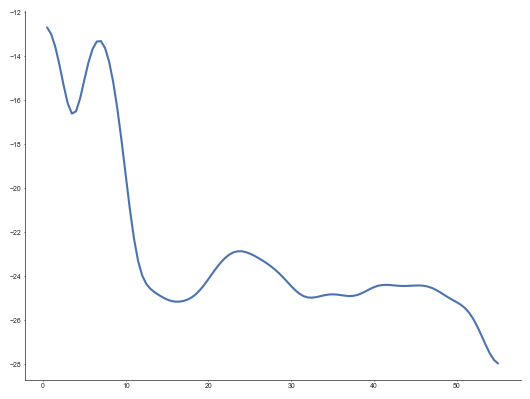

In [ ]:
# pacu_spectral_prop = np.array(pacu_spectral_prop) 
# idx = np.where(pacu_spectral_prop < 0)[0]
# # print(idx)
# p_ids = np.array(list(pacu_spectral_prop_dict.keys()))


# plt.figure()
# plt.plot(fregs, pacu_psds[p_ids[idx[0]]])

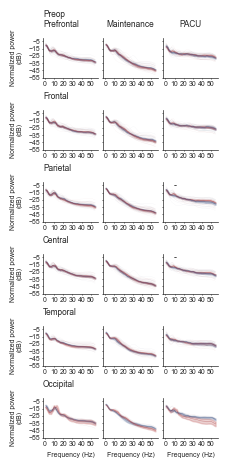

In [ ]:
from scipy.stats import wilcoxon

# orange = "#ff7f0e"
green = "#228B22"
purple = "#9467bd"
gray = "#535353"  # Gray Color for Violin Plots

freqs = loaded_power_spectral.frequencies

def extract_psds_group_averages(region):
    preop_psds = {}
    maintenance_psds = {}
    pacu_psds = {}
    for p in win_center:
        # Group A or B
        # Extracting and processing PSDs
        preop_psd = psd[p][region]['preop_rest'].flatten()
        pacu_psd = psd[p][region]['pacu_rest'].flatten()
        maintenance_psd = np.nanmean(psd[p][region]['emergence'], axis=1).flatten()
        if (group_label[p] == 'A' or group_label[p] == 'B') and np.sum(preop_psd) > 1 and np.sum(pacu_psd) > 1 and np.sum(maintenance_psd) > 1:    

            preop_psd = preop_psd/np.nansum(preop_psd)
            pacu_psd = pacu_psd/np.nansum(pacu_psd)
            maintenance_psd = maintenance_psd/np.nansum(maintenance_psd)

            preop_psd[preop_psd == 0] = 1e-16
            pacu_psd[pacu_psd == 0] = 1e-16
            maintenance_psd[maintenance_psd == 0] = 1e-16

            preop_psds[p] = 10*np.log10(preop_psd)
            pacu_psds[p] = 10*np.log10(pacu_psd)
            maintenance_psds[p] = 10*np.log10(maintenance_psd)

    # Processing PSD data for group A and B pateint data
    # preop
    groupA_preop_psds = {p: preop_psds[p] for p in group_label if group_label[p] == 'A' and p in preop_psds}
    groupA_preop_data = np.vstack(list(groupA_preop_psds.values()))
    groupA_preop_med_psd = np.nanmedian(groupA_preop_data, axis=0)
    groupA_preop_sem_psd = bootstrap_sem(groupA_preop_data)

    groupB_preop_psds = {p: preop_psds[p] for p in group_label if group_label[p] == 'B' and p in preop_psds}
    groupB_preop_data = np.vstack(list(groupB_preop_psds.values()))
    groupB_preop_med_psd = np.nanmedian(groupB_preop_data, axis=0)
    groupB_preop_sem_psd = bootstrap_sem(groupB_preop_data)

    # maintenace 
    groupA_maintenance_psds = {p: maintenance_psds[p] for p in group_label if group_label[p] == 'A' and p in preop_psds}
    groupA_maintenance_data = np.vstack(list(groupA_maintenance_psds.values()))
    groupA_maintenance_med_psd = np.nanmedian(groupA_maintenance_data, axis=0)
    groupA_maintenance_sem_psd = bootstrap_sem(groupA_maintenance_data)

    groupB_maintenance_psds = {p: maintenance_psds[p] for p in group_label if group_label[p] == 'B' and p in preop_psds}
    groupB_maintenance_data = np.vstack(list(groupB_maintenance_psds.values()))
    groupB_maintenance_med_psd = np.nanmedian(groupB_maintenance_data, axis=0)
    groupB_maintenance_sem_psd = bootstrap_sem(groupB_maintenance_data)

    # PACU
    groupA_pacu_psds = {p: pacu_psds[p] for p in group_label if group_label[p] == 'A' and p in preop_psds}
    groupA_pacu_data = np.vstack(list(groupA_pacu_psds.values()))
    groupA_pacu_med_psd = np.nanmedian(groupA_pacu_data, axis=0)
    groupA_pacu_sem_psd = bootstrap_sem(groupA_pacu_data)

    groupB_pacu_psds = {p: pacu_psds[p] for p in group_label if group_label[p] == 'B' and p in preop_psds}
    groupB_pacu_data = np.vstack(list(groupB_pacu_psds.values()))
    groupB_pacu_med_psd = np.nanmedian(groupB_pacu_data, axis=0)
    groupB_pacu_sem_psd = bootstrap_sem(groupB_pacu_data)

    return (
        groupA_preop_psds, groupA_preop_med_psd, groupA_preop_sem_psd, 
        groupB_preop_psds, groupB_preop_med_psd, groupB_preop_sem_psd,
        groupA_maintenance_psds, groupA_maintenance_med_psd, groupA_maintenance_sem_psd, 
        groupB_maintenance_psds, groupB_maintenance_med_psd, groupB_maintenance_sem_psd,
        groupA_pacu_psds, groupA_pacu_med_psd, groupA_pacu_sem_psd, 
        groupB_pacu_psds, groupB_pacu_med_psd, groupB_pacu_sem_psd,
    )

# Define figure properties
set_custom_style()

plot_width = 60 * 3
plot_height = 80 * len(region_names)

fig, axs = plt.subplots(len(region_names), 3, figsize=(plot_width/72 , plot_height/72))

# Loop over each region
for region_idx, region in enumerate(region_names):
    
    (
        groupA_preop_psds, groupA_preop_med_psd, groupA_preop_sem_psd, 
        groupB_preop_psds, groupB_preop_med_psd, groupB_preop_sem_psd,
        groupA_maintenance_psds, groupA_maintenance_med_psd, groupA_maintenance_sem_psd, 
        groupB_maintenance_psds, groupB_maintenance_med_psd, groupB_maintenance_sem_psd,
        groupA_pacu_psds, groupA_pacu_med_psd, groupA_pacu_sem_psd, 
        groupB_pacu_psds, groupB_pacu_med_psd, groupB_pacu_sem_psd,
    ) = extract_psds_group_averages(
        region
    )
    

    # Plot the preop PSDs for group A and B
    ax = axs[region_idx, 0]

    # group A:
    for p, p_psd in groupA_preop_psds.items():
        ax.plot(freqs, p_psd, blue, alpha=0.1, linewidth = 0.1)
    
    # group B:
    for p, p_psd in groupB_preop_psds.items():
        ax.plot(freqs, p_psd, red, alpha=0.1, linewidth = 0.1)
    
    ax.plot(freqs, groupA_preop_med_psd, blue, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupA_preop_med_psd - groupA_preop_sem_psd, groupA_preop_med_psd + groupA_preop_sem_psd, color=blue, alpha=0.2)

    ax.plot(freqs, groupB_preop_med_psd, red, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupB_preop_med_psd - groupB_preop_sem_psd, groupB_preop_med_psd + groupB_preop_sem_psd, color=red, alpha=0.2)
    
    ax.set_xticks(np.arange(0, 55, 10))

    ax.set_ylim([-55, 0])
    # ax.set_ylim([0, 50])
    yl = ax.get_ylim()
    ax.set_yticks(np.arange(yl[0], yl[1], 10))
    if region_idx == 0:
        ax.set_title(f'Preop\n{region.capitalize()}', va = 'bottom', ha = 'left', loc='left')
    else:
        ax.set_title(f'{region.capitalize()}', va = 'bottom', ha = 'left', loc = 'left')
    
    if region_idx== 5:
        ax.set_xlabel('Frequency (Hz)')
    
    ax.set_ylabel('Normalized power\n(dB)')

    y=-5
    groupA_psds = np.vstack(list(groupA_preop_psds.values()))
    groupB_psds = np.vstack(list(groupB_preop_psds.values()))
    for freq_idx , freq in enumerate(freqs):
        p_value = ranksums(groupA_psds[:, freq_idx], groupB_psds[:, freq_idx]).pvalue
        if p_value < 0.05:
            ax.plot([freq-0.1, freq+0.1], [y, y], color='k', lw=0.5)


    # Plot the maintenance PSDs for group A and B
    ax = axs[region_idx, 1]

    # group A:
    for p, p_psd in groupA_maintenance_psds.items():
        ax.plot(freqs, p_psd, blue, alpha=0.1, linewidth = 0.1)
    
    # group B:
    for p, p_psd in groupB_maintenance_psds.items():
        ax.plot(freqs, p_psd, red, alpha=0.1, linewidth = 0.1)
    
    ax.plot(freqs, groupA_maintenance_med_psd, blue, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupA_maintenance_med_psd - groupA_maintenance_sem_psd, groupA_maintenance_med_psd + groupA_maintenance_sem_psd, color=blue, alpha=0.2)
    
    ax.plot(freqs, groupB_maintenance_med_psd, red, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupB_maintenance_med_psd - groupB_maintenance_sem_psd, groupB_maintenance_med_psd + groupB_maintenance_sem_psd, color=red, alpha=0.2)

    ax.set_xticks(np.arange(0, 55, 10))

    ax.set_ylim([-55, 0])
    # ax.set_ylim([0, 50])
    yl = ax.get_ylim()
    ax.set_yticks(np.arange(yl[0], yl[1], 10))    
    if region_idx== 5:
        ax.set_xlabel('Frequency (Hz)')    
    ax.set_yticklabels("")

    if region_idx == 0:
        ax.set_title('Maintenance', va = 'bottom', ha = 'center', loc='center')

    groupA_psds = np.vstack(list(groupA_maintenance_psds.values()))
    groupB_psds = np.vstack(list(groupB_maintenance_psds.values()))
    for freq_idx , freq in enumerate(freqs):
        p_value = ranksums(groupA_psds[:, freq_idx], groupB_psds[:, freq_idx]).pvalue
        if p_value < 0.05:
            ax.plot([freq-0.1, freq+0.1], [y, y], color='k', lw=0.5)


    # Plot the PACU PSDs for group A and B
    ax = axs[region_idx, 2]

    # group A:
    for p, p_psd in groupA_pacu_psds.items():
        ax.plot(freqs, p_psd, blue, alpha=0.1, linewidth = 0.1)
    
    # group B:
    for p, p_psd in groupB_pacu_psds.items():
        ax.plot(freqs, p_psd, red, alpha=0.1, linewidth = 0.1)

    ax.plot(freqs, groupB_pacu_med_psd, red, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupB_pacu_med_psd - groupB_pacu_sem_psd, groupB_pacu_med_psd + groupB_pacu_sem_psd, color=red, alpha=0.2)

    ax.plot(freqs, groupA_pacu_med_psd, blue, linewidth=0.3, alpha=0.5)
    ax.fill_between(freqs, groupA_pacu_med_psd - groupA_pacu_sem_psd, groupA_pacu_med_psd + groupA_pacu_sem_psd, color=blue, alpha=0.2)

    ax.set_xticks(np.arange(0, 55, 10))

    ax.set_ylim([-55, 0])
    # ax.set_ylim([0, 50])
    yl = ax.get_ylim()
    ax.set_yticks(np.arange(yl[0], yl[1], 10))
    if region_idx == 5:
        ax.set_xlabel('Frequency (Hz)')    
    ax.set_yticklabels("")
    if region_idx == 0:
        ax.set_title('PACU', va = 'bottom', ha = 'center', loc='center')

    groupA_psds = np.vstack(list(groupA_pacu_psds.values()))
    groupB_psds = np.vstack(list(groupB_pacu_psds.values()))
    for freq_idx , freq in enumerate(freqs):
        p_value = ranksums(groupA_psds[:, freq_idx], groupB_psds[:, freq_idx]).pvalue
        if p_value < 0.05:
            ax.plot([freq-0.1, freq+0.1], [y, y], color='k', lw=0.5)

plt.tight_layout()
plt.subplots_adjust(left=0.2, right= 0.9, bottom=0.2, top=0.8, wspace=0.1, hspace=0.8)

main_dir = 'E:/Caffeine_data/'
filename = 'PSDs_groupA_vs_B_normalized.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

### Trash

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from scipy.stats import ranksums
from matplotlib.patches import Rectangle

# Set the normalization flags
NORMALIZE_AMP = True
NORMALIZE_TIME = True

spectral_metric = reg_fit_slope 
min_acceptable_vlue = 0.01

blue = "#1f3b73"  # Dark Blue
red = "#a82323"  # Dark Red

def calculate_normalization_factor(win_center_dic, slope_dict):
    pre_infusion_mean_std = {}
    for p, times in win_center_dic.items():
        times = np.asarray(times).flatten()
        slopes = np.asarray(slope_dict[p]).flatten()
        if np.sum(slopes) > min_acceptable_vlue:  # Ensure the slopes are not entirely zero
            # Calculate mean and std of slopes with window_center less than 600
            slopes_less_600 = slopes[times < 600]
            # pre_infusion_mean_std[p] = (np.nanmean(slopes_less_600), np.nanstd(slopes_less_600))
            pre_infusion_mean_std[p] = (np.nanmax(slopes_less_600), np.nan)
        else:
            pre_infusion_mean_std[p] = (np.nan, np.nan)
            
    return pre_infusion_mean_std

def normalize_time(win_center_dict, slope_dict):
    max_patient = max(win_center_dict, key=lambda k: len(win_center_dict[k]))
    num_time_points = len(win_center_dict[max_patient])
    
    max_time = win_center_dict[max_patient][-1]
    
    all_win_centers = np.linspace(0, max_time, num_time_points)

    slope_dict_normal_time = {}
    win_center_normal_time = {}
    for p, times in win_center_dict.items():
        win_center_normal_time[p] = all_win_centers

        times = np.asarray(times).flatten()
        slopes = np.asarray(slope_dict[p]).flatten()
        
        # Interpolate slopes to match the new time points
        new_times = np.linspace(times[0], times[-1], num_time_points)
        slopes = np.interp(new_times, times, slopes)
        slope_dict_normal_time[p] = slopes

    return win_center_normal_time, slope_dict_normal_time

def bootstrap_sem(data, num_bootstrap=1000):
    n = data.shape[1]
    boot_medians = np.zeros((num_bootstrap, n))
    for i in range(num_bootstrap):
        samples = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
        boot_medians[i, :] = np.nanmedian(data[samples, :], axis=0)
    return np.nanstd(boot_medians, axis=0, ddof=1)

def align_and_average(win_center_dict, slope_dict, normalize_factor):

    all_win_centers = sorted(set().union(*win_center_dict.values()))
        
    avg_dict = {}
    for p, times in win_center_dict.items():
        try:
            times = np.asarray(times).flatten()
            slopes = np.asarray(slope_dict[p]).flatten()
            if np.sum(slopes) > 0.1:  # Ensure the slopes are not entirely zero
                interpolated_slopes = np.interp(all_win_centers, times, slopes)
                interpolated_slopes[all_win_centers > times[-1]] = np.nan
                
                if NORMALIZE_AMP:
                    # Normalize slopes
                    # slopes = z_score(slopes, normalize_factor[p])
                    mean, _ = normalize_factor[p]
                    interpolated_slopes = interpolated_slopes / mean
                    
                avg_dict[p] = interpolated_slopes
        except Exception as e:
            warnings.warn(f"Warning: An error occurred while aligning and averaging for patient {p}: {e}", UserWarning)
    
    # Stack all patient data together
    data = np.vstack(list(avg_dict.values()))
    
    # Non-parametric median
    median_all = np.nanmedian(data, axis=0)
    
    # Bootstrapped SEM
    sem_all = bootstrap_sem(data)
    
    return np.array(all_win_centers), median_all, sem_all

# def align_and_average(win_center_dict, slope_dict, normalize_factor):

#     all_win_centers = sorted(set().union(*win_center_dict.values()))
        
#     avg_dict = {}
#     for p, times in win_center_dict.items():
#         try:
#             times = np.asarray(times).flatten()
#             slopes = np.asarray(slope_dict[p]).flatten()
#             if np.sum(slopes) > 0.1:  # Ensure the slopes are not entirely zero
#                 if NORMALIZE_AMP:
#                     # Normalize slopes
#                     slopes = z_score(slopes, normalize_factor[p])
#                 else:
#                     interpolated_slopes = np.interp(all_win_centers, times, slopes)
#                     interpolated_slopes[all_win_centers > times[-1]] = np.nan
#                     slopes = interpolated_slopes
                    
#                 avg_dict[p] = slopes
#         except Exception as e:
#             warnings.warn(f"Warning: An error occurred while aligning and averaging for patient {p}: {e}", UserWarning)
            
#     avg_all = np.nanmean(np.vstack(list(avg_dict.values())), axis=0)
#     sem_all = np.nanstd(np.vstack(list(avg_dict.values())), axis=0) / np.sqrt(len(avg_dict))
    
#     return np.array(all_win_centers), avg_all, sem_all

def flatten_and_filter(data):
    flatten_data = []
    for sublist in data:
        if isinstance(sublist, (list, np.ndarray)):
            for item in sublist:
                if item is not None: 
                    flatten_data.append(item)
        elif isinstance(sublist, (float, int, np.float64, np.int64)):  
            flatten_data.append(sublist)
    return flatten_data

def z_score(data, mean_std):
    mean, std = mean_std
    return (data - mean) / std

def apply_normalization(data, mean_std):
    if NORMALIZE_AMP:
        mean, _ = mean_std
        return data/mean
        # return z_score(data, mean_std)
    return data

# Define figure properties
plot_width = 250
plot_height = 100 * len(region_names)
set_custom_style()
fig, axs = plt.subplots(len(region_names), 3, figsize=(plot_width/72, plot_height/72), gridspec_kw={'width_ratios': [0.1, 1, 0.1]})

if len(region_names) == 1:
    axs = [axs]  # Ensure axs is iterable when there is only one region

# Loop over each region
for idx, region in enumerate(region_names):
    win_center_emergence = {p: win_center[p][region]['emergence'] for p in win_center if np.sum(spectral_metric[p][region]['emergence']) > min_acceptable_vlue}
    reg_fit_slope_emergence = {p: spectral_metric[p][region]['emergence'] for p in spectral_metric if np.sum(spectral_metric[p][region]['emergence']) > min_acceptable_vlue}

    if NORMALIZE_TIME:
        win_center_emergence, reg_fit_slope_emergence =  normalize_time( win_center_emergence, reg_fit_slope_emergence)

    # Calculate normalization factor for each patient
    normalize_factor = calculate_normalization_factor(win_center_emergence, reg_fit_slope_emergence)

    # Plot preop_rest violin and strip plots
    ax_preop = axs[idx, 0]
    preop_rest_groupA = [apply_normalization(spectral_metric[p][region]['preop_rest'], normalize_factor[p]) for p in group_label if group_label[p] == 'A' and p in normalize_factor and spectral_metric[p][region]['preop_rest'] > min_acceptable_vlue]
    preop_rest_groupB = [apply_normalization(spectral_metric[p][region]['preop_rest'], normalize_factor[p]) for p in group_label if group_label[p] == 'B' and p in normalize_factor and spectral_metric[p][region]['preop_rest'] > min_acceptable_vlue]
    preop_rest_groupA = flatten_and_filter(preop_rest_groupA)
    preop_rest_groupB = flatten_and_filter(preop_rest_groupB)
    
    sns.violinplot(data=[preop_rest_groupA, preop_rest_groupB], ax=ax_preop, cut=0, inner='quart', density_norm='area', split=True, palette=[blue, red], linewidth=0.5, alpha=0.3)
    sns.stripplot(data=[preop_rest_groupA, preop_rest_groupB], ax=ax_preop, jitter=True, edgecolor='auto', size=1, palette=[blue, red], alpha=0.8)
    
    ax_preop.set_xticks([0, 1])
    ax_preop.set_xticklabels(['Group A', 'Group B'], rotation=45)
    ax_preop.set_ylim([0, 1.6])
    ax_preop.set_title(f"{region.capitalize()}\nPreop-Rest")
    if NORMALIZE_AMP:
        ax_preop.set_ylabel('Spectral slope\n(normalized)')
    else:
        ax_preop.set_ylabel('Spectral slope\n(dB/Hz)')

    ax_preop.spines['top'].set_visible(False)
    ax_preop.spines['right'].set_visible(False)

    for line in ax_preop.lines:
        line.set_linestyle('-')
        line.set_linewidth(0.4)

    # Perform ranksum test and add significance line
    y = 1.5
    ax_preop.plot([0, 1], [y, y], color='k', lw=0.5)
    p_value = ranksums(preop_rest_groupA, preop_rest_groupB).pvalue
    ax_preop.text(0.5, y + 0.05, f'{p_value:.2f}', ha='center', fontsize=5)
    
    # Plot emergence line plots
    ax_emergence = axs[idx, 1]
    for p in win_center_emergence:
        times = np.asarray(win_center_emergence[p]).flatten()
        slopes = np.asarray(reg_fit_slope_emergence[p]).flatten()
            
        norm_slopes = apply_normalization(slopes, normalize_factor[p])
        
        if group_label[p] == 'A':
            ax_emergence.plot(times - 600, norm_slopes, '-', color=blue, label='Group A' if 'Group A' not in ax_emergence.get_legend_handles_labels()[1] else "", linewidth=0.25, alpha=0.2)
        elif group_label[p] == 'B':
            ax_emergence.plot(times - 600, norm_slopes, '-', color=red, label='Group B' if 'Group B' not in ax_emergence.get_legend_handles_labels()[1] else "", linewidth=0.25, alpha=0.2)

    # Split data by group
    groupA_prefrontal_data = {p: win_center_emergence[p] for p in group_label if group_label[p] == 'A' and p in win_center_emergence}
    groupB_prefrontal_data = {p: win_center_emergence[p] for p in group_label if group_label[p] == 'B' and p in win_center_emergence}
    groupA_slope_data = {p: reg_fit_slope_emergence[p] for p in group_label if group_label[p] == 'A' and p in reg_fit_slope_emergence}
    groupB_slope_data = {p: reg_fit_slope_emergence[p] for p in group_label if group_label[p] == 'B' and p in reg_fit_slope_emergence}

    avg_win_centers_A, avg_slopes_A, sem_A = align_and_average(groupA_prefrontal_data, groupA_slope_data, normalize_factor)
    avg_win_centers_B, avg_slopes_B, sem_B = align_and_average(groupB_prefrontal_data, groupB_slope_data, normalize_factor)

    # Plot averages with SEM
    ax_emergence.plot(avg_win_centers_A - 600, avg_slopes_A, '-', color=blue, linewidth=0.5, label='Avg Group A')
    ax_emergence.fill_between(avg_win_centers_A - 600, avg_slopes_A - sem_A, avg_slopes_A + sem_A, color=blue, alpha=0.5)
    # ax_emergence.plot(avg_win_centers_A - 600, avg_slopes_A + sem_A, color=blue, linestyle='--', linewidth=0.3)
    # ax_emergence.plot(avg_win_centers_A - 600, avg_slopes_A - sem_A, color=blue, linestyle='--', linewidth=0.3)

    ax_emergence.plot(avg_win_centers_B - 600, avg_slopes_B, '-', color=red, linewidth=0.5, label='Avg Group B')
    ax_emergence.fill_between(avg_win_centers_B - 600, avg_slopes_B - sem_B, avg_slopes_B + sem_B, color=red, alpha=0.5)
    # ax_emergence.plot(avg_win_centers_B - 600, avg_slopes_B + sem_B, color=red, linestyle='--', linewidth=0.3)
    # ax_emergence.plot(avg_win_centers_B - 600, avg_slopes_B - sem_B, color=red, linestyle='--', linewidth=0.3)


    ax_emergence.set_title('Peri-drug infusion')
    ax_emergence.set_xticks(np.arange(0, win_center_emergence['CA-01'][-1], 1000))
    ax_emergence.set_xlabel('Time (sec)')
    ax_emergence.set_yticklabels('')

    if idx == 0:
        ax_legend = fig.add_subplot([0.65, 0.88, 0.1, 0.05])
        legend_lines, legend_labels = ax_emergence.get_legend_handles_labels()
        ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=5)
        ax_legend.spines['bottom'].set_visible(False)
        ax_legend.spines['left'].set_visible(False)
        ax_legend.set_xticks([])
        ax_legend.set_yticks([])
        ax_legend.tick_params(bottom=False, left=False)
        ax_legend.set_facecolor('none')

    ax_emergence.set_ylim([0, 1.6])
    ax_emergence.set_xlim([-700, win_center_emergence['CA-01'][-1]])

    if NORMALIZE_AMP:
        start_time = -600
        end_time = 0
        yl = ax_emergence.get_ylim()
        rect = Rectangle((start_time, yl[0]), end_time - start_time, yl[1]-yl[0], facecolor='gray', alpha=0.2)
        ax_emergence.add_patch(rect)

    ax_emergence.spines['top'].set_visible(False)
    ax_emergence.spines['right'].set_visible(False)
    
    # Perform ranksum test for each time point and add significance asterisks
    diff_time = avg_win_centers_A[1] - avg_win_centers_A[0]
    for i, time_point in enumerate(avg_win_centers_A):
        groupA_at_time = [apply_normalization(reg_fit_slope_emergence[p][np.argmin(np.abs(win_center_emergence[p] - time_point))], normalize_factor[p]) for p in groupA_prefrontal_data if time_point in win_center_emergence[p]]
        groupB_at_time = [apply_normalization(reg_fit_slope_emergence[p][np.argmin(np.abs(win_center_emergence[p] - time_point))], normalize_factor[p]) for p in groupB_prefrontal_data if time_point in win_center_emergence[p]]
        if groupA_at_time and groupB_at_time:
            p_value = ranksums(groupA_at_time, groupB_at_time).pvalue
            if p_value < 0.05:
                ax_emergence.plot([time_point-600-(diff_time/2), time_point-600+(diff_time/2)], [y, y], color='k', lw=0.5)

    # Plot pacu_rest violin and strip plots
    ax_pacu = axs[idx, 2]
    pacu_rest_groupA = [apply_normalization(spectral_metric[p][region]['pacu_rest'], normalize_factor[p]) for p in group_label if group_label[p] == 'A' and p in normalize_factor and spectral_metric[p][region]['pacu_rest'] > min_acceptable_vlue]
    pacu_rest_groupB = [apply_normalization(spectral_metric[p][region]['pacu_rest'], normalize_factor[p]) for p in group_label if group_label[p] == 'B' and p in normalize_factor and spectral_metric[p][region]['pacu_rest'] > min_acceptable_vlue]
    pacu_rest_groupA = flatten_and_filter(pacu_rest_groupA)
    pacu_rest_groupB = flatten_and_filter(pacu_rest_groupB)
    
    sns.violinplot(data=[pacu_rest_groupA, pacu_rest_groupB], ax=ax_pacu, cut=0, inner='quart', density_norm='area', split=True, palette=[blue, red], linewidth=0.5, alpha=0.3)
    sns.stripplot(data=[pacu_rest_groupA, pacu_rest_groupB], ax=ax_pacu, jitter=True, edgecolor='auto', size=1, palette=[blue, red], alpha=0.8)
    
    ax_pacu.set_xticks([0, 1])
    ax_pacu.set_xticklabels(['Group A', 'Group B'], rotation=45)
    ax_pacu.set_yticklabels('')
    ax_pacu.set_ylim([0, 1.6])

    ax_pacu.set_title('PACU-rest')

    ax_pacu.spines['top'].set_visible(False)
    ax_pacu.spines['right'].set_visible(False)

    for line in ax_pacu.lines:
        line.set_linestyle('-')
        line.set_linewidth(0.4)

    # Perform ranksum test and add significance line
    ax_pacu.plot([0, 1], [y, y], color='k', lw=0.5)
    p_value = ranksums(pacu_rest_groupA, pacu_rest_groupB).pvalue
    ax_pacu.text(0.5, y + 0.05, f'{p_value:.2f}', ha='center', fontsize=5)

plt.tight_layout()
plt.subplots_adjust(left=0.1, right= 0.9, bottom=0.1, top=0.9, wspace=0.05)

main_dir = 'E:/Caffeine_data/'

filename = 'power_spectral_slope_groupA_vs_groupB'
if NORMALIZE_AMP:
    filename += '_normalized_to_pre_infusion'
if NORMALIZE_TIME:
    filename += '_time_normalized'
filename += '.pdf'

file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()